In [36]:
from langdetect import detect, LangDetectException
import matplotlib.pyplot as plt
import pandas as pd
import re
import joblib
from xgboost import XGBClassifier
import string
import nltk
from nltk.corpus import stopwords
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2

In [37]:
# Chargement des données à partir d'un fichier CSV
df = pd.read_csv("Datafiniti_Hotel_Reviews_Jun19.csv", sep=',')

In [38]:
# Sélection des colonnes pertinentes pour l'analyse
df = df.loc[:, ['reviews.rating', 'reviews.text', 'reviews.title']]
df

,reviews.rating,reviews.text,reviews.title
0,3,"This hotel was nice and quiet. Did not know, t...",Best Western Plus Hotel
1,4,We stayed in the king suite with the separatio...,Clean rooms at solid rates in the heart of Carmel
2,3,"Parking was horrible, somebody ran into my ren...",Business
3,5,Not cheap but excellent location. Price is som...,Very good
4,2,If you get the room that they advertised on th...,Low chance to come back here
...,...,...,...
9995,4,My friends and I took a trip to Hampton for th...,Very accommodating and friendly staff!
9996,5,"from check in to departure, staff is friendly,...","comfortable, friendly, clean, professional"
9997,5,This Hampton is located on a quiet street acro...,Great location
9998,5,Awesome wings (my favorite was garlic parmesan...,Great Atmosphere!


In [39]:
# Conversion des types de données pour s'assurer de leur uniformité
df = df.astype({'reviews.rating': 'int', 'reviews.title': 'str', 'reviews.text': 'str'})

In [40]:
# Concaténation du titre et du texte des avis pour enrichir les données textuelles
df.loc[:, 'reviews.text'] = df.apply(lambda row: str(row['reviews.title']) + ". " + str(row['reviews.text']), axis=1)
if "reviews.title" in df.columns:
    df = df.drop("reviews.title", axis=1)# Suppression de la colonne du titre après concaténation

In [41]:
df

,reviews.rating,reviews.text
0,3,Best Western Plus Hotel. This hotel was nice a...
1,4,Clean rooms at solid rates in the heart of Car...
2,3,"Business. Parking was horrible, somebody ran i..."
3,5,Very good. Not cheap but excellent location. P...
4,2,Low chance to come back here. If you get the r...
...,...,...
9995,4,Very accommodating and friendly staff!. My fri...
9996,5,"comfortable, friendly, clean, professional. fr..."
9997,5,Great location. This Hampton is located on a q...
9998,5,Great Atmosphere!. Awesome wings (my favorite ...


In [42]:
# Nettoyage des données en supprimant les lignes sans notes ou texte et les doublons
df = df.dropna(subset=['reviews.rating', 'reviews.text'])
df = df.drop_duplicates()

In [43]:
# Nettoyage du texte des avis en supprimant les caractères spéciaux
df['reviews.text'] = df['reviews.text'].str.replace('[^a-zA-Z0-9 @]', '', regex=True)
df = df.dropna(subset=['reviews.text'])
df = df[df['reviews.text'] != '']

In [44]:
# Détection de la langue des avis pour filtrer et garder uniquement ceux en anglais
def detect_language(text):
    try:
        return detect(text)
    except LangDetectException:
        return 'Unknown'
    
df['language'] = df['reviews.text'].apply(detect_language)
df = df.loc[df['language'] == 'en']

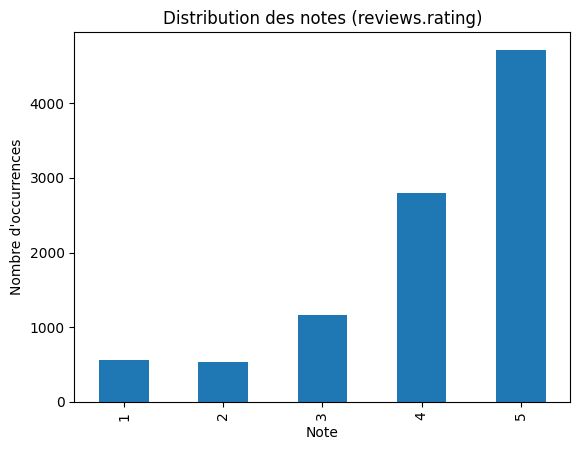

In [45]:
# Visualisation de la distribution des notes pour comprendre l'équilibre des classes
rating_counts = df['reviews.rating'].value_counts().sort_index()
all_ratings = pd.Series(index=range(1, 6), data=0)  # Initialiser les notes de 1 à 5 à 0
rating_counts = all_ratings.add(rating_counts, fill_value=0).astype(int)  # Ajouter les comptes existants
rating_counts.plot(kind='bar')
plt.title('Distribution des notes (reviews.rating)')
plt.xlabel('Note')
plt.ylabel('Nombre d\'occurrences')
plt.show()

In [46]:
# Nettoyage du texte en supprimant les mots vides pour réduire le bruit dans les données textuelles
def remove_stopwords(text):
    en_stopwords = stopwords.words('english')  # Use English stop words
    text = [word for word in text.split() if word not in en_stopwords]
    return " ".join(text)  # Join back into a string

In [47]:
# Prétraitement du texte pour le normaliser : conversion en minuscules, suppression de la ponctuation et des mots vides
def clean_text(text):
    text = text.lower()
    text = "".join([char for char in text if char not in string.punctuation])
    text = remove_stopwords(text)
    return text

In [48]:
# Vectorisation du texte avec TF-IDF pour transformer le texte en une représentation numérique utilisable par les modèles d'IA
tfidf_vectorizer_1000 = TfidfVectorizer(max_features=1000)
X_tfidf_1000 = tfidf_vectorizer_1000.fit_transform(df['reviews.text']).toarray()
np.save('X_tfidf_1000.npy', X_tfidf_1000)

tfidf_vectorizer_3000 = TfidfVectorizer(max_features=3000)
X_tfidf_3000 = tfidf_vectorizer_3000.fit_transform(df['reviews.text']).toarray()
np.save('X_tfidf_3000.npy', X_tfidf_3000)

In [49]:
# Préparation des étiquettes (y) pour l'entraînement des modèles

y = df['reviews.rating'].values
np.save('y.npy', y)

In [50]:
# Lemmatisation du texte pour ramener les mots à leur racine, réduisant ainsi la complexité du modèle

from nltk import WordNetLemmatizer
#nltk.download('wordnet')

def preprocess_text(text):
    text = re.sub(r'https?://\S+|www\.\S+', '', text)
    text = re.sub(r'<.*?>', '', text)
    text = text.encode('ascii', 'ignore').decode('utf-8', 'ignore')
    lemmatizer = WordNetLemmatizer()
    text = ' '.join([lemmatizer.lemmatize(word) for word in text.split()])
    return text

df.loc[:, 'reviews.text'] = df['reviews.text'].apply(preprocess_text)

In [51]:
# Tokenisation et padding des séquences de texte pour préparer les données à l'entraînement de modèles basés sur des réseaux de neurones

tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")
tokenizer.fit_on_texts(df['reviews.text'])
sequences = tokenizer.texts_to_sequences(df['reviews.text'])
padded_sequences = pad_sequences(sequences, padding='post', maxlen=120)

### Model TensorFlow

In [52]:
X = np.load('X_tfidf_3000.npy')
y = np.load('y.npy')

#Divise les données en ensembles d'entraînement et de test, permettant de tester la performance du modèle sur des données non vues lors de l'entraînement.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [53]:
#Régularisation L2 : l2(0.001) applique une pénalité L2 aux coefficients du modèle, encourageant des poids plus petits pour réduire la complexité du modèle et prévenir le surapprentissage. La valeur 0.001 est le coefficient de régularisation qui contrôle l'ampleur de cette pénalité.
regularizer = l2(0.001)

#La construction du modèle est faite avec Keras. Le modèle est composé de trois couches Dense avec des activations relu pour les deux premières et softmax pour la sortie, intégrant la régularisation L2 pour réduire le risque de surapprentissage. Des couches Dropout sont utilisées pour ajouter de l'aléatoire dans le processus d'entraînement, en "éteignant" aléatoirement certains neurones pendant l'entraînement, ce qui aide également à prévenir le surapprentissage.

#On à fait cela car au départ nous étions en surapprentissage.

model = Sequential([
    Dense(512, activation='relu', input_shape=(X_train.shape[1],), kernel_regularizer=regularizer),
    Dropout(0.5),
    Dense(256, activation='relu', kernel_regularizer=regularizer),
    Dropout(0.5),
    Dense(5, activation='softmax', kernel_regularizer=regularizer)
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

#EarlyStopping : Cette technique arrête l'entraînement lorsque la performance sur l'ensemble de validation commence à se dégrader, indiquée par une augmentation de val_loss pendant un nombre défini de patience époques. Ici, patience=10 signifie que l'entraînement s'arrêtera si aucune amélioration n'est observée sur val_loss pendant 10 époques consécutives. restore_best_weights=True assure que le modèle retourné a les poids de l'époque avec la meilleure performance sur l'ensemble de validation, ce qui permet d'éviter le surapprentissage et d'obtenir un modèle bien généralisé.

earlyStopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True);

y_train_adj = y_train - 1
y_test_adj = y_test - 1

In [54]:
#Le modèle est entraîné avec un nombre maximal de 100 époques, mais l'entraînement peut s'arrêter plus tôt grâce à EarlyStopping. Une fraction des données d'entraînement est utilisée comme validation pour surveiller la performance du modèle.
history = model.fit(X_train, y_train_adj, epochs=100, batch_size=32, validation_split=0.2, callbacks=[earlyStopping]);

Epoch 1/100
196/196 [==============================] - 1s 5ms/step - loss: 1.4072 - accuracy: 0.5393 - val_loss: 1.1075 - val_accuracy: 0.6068
Epoch 2/100
196/196 [==============================] - 1s 4ms/step - loss: 1.0697 - accuracy: 0.6435 - val_loss: 1.1134 - val_accuracy: 0.6349
Epoch 3/100
196/196 [==============================] - 1s 4ms/step - loss: 1.0100 - accuracy: 0.6835 - val_loss: 1.0737 - val_accuracy: 0.6362
Epoch 4/100
196/196 [==============================] - 1s 5ms/step - loss: 0.9850 - accuracy: 0.6923 - val_loss: 1.0984 - val_accuracy: 0.6253
Epoch 5/100
196/196 [==============================] - 1s 5ms/step - loss: 0.9703 - accuracy: 0.7123 - val_loss: 1.0976 - val_accuracy: 0.6381
Epoch 6/100
196/196 [==============================] - 1s 5ms/step - loss: 0.9524 - accuracy: 0.7202 - val_loss: 1.1161 - val_accuracy: 0.6343
Epoch 7/100
196/196 [==============================] - 1s 5ms/step - loss: 0.9405 - accuracy: 0.7356 - val_loss: 1.1357 - val_accuracy: 0.6407

In [55]:
loss, accuracy = model.evaluate(X_test, y_test_adj)
print(f'Test Loss: {loss:.3f}, Test Accuracy: {accuracy:.3f}')

62/62 [==============================] - 0s 2ms/step - loss: 1.1090 - accuracy: 0.6320
Test Loss: 1.109, Test Accuracy: 0.632


In [56]:
# Transformer l'avis en utilisant le vectoriseur TF-IDF chargé
new_review_vector = tfidf_vectorizer_3000.transform(["My experience at the hotel was decidedly underwhelming. Firstly, the location, while central, was a double-edged sword; the incessant noise from the street made a good night's sleep a rare luxury. The staff, although polite, seemed overwhelmed and occasionally unresponsive to requests for basic amenities. The room itself was a major letdown - cramped, with dated decor that felt more depressing than retro. The bed was uncomfortable, and the linens had seen better days. The air conditioning was more of a whisper than a relief, contributing to an overall stifling atmosphere. The breakfast, which I had looked forward to, was a disappointing affair with limited choices and stale pastries. In summary, the hotel was more a lesson in patience than a place of rest and relaxation."]).toarray()

In [57]:
prediction = model.predict(new_review_vector)
predicted_rating = np.argmax(prediction) + 1
print(f'Note prédite: {predicted_rating}')

1/1 [==============================] - 0s 21ms/step
Note prédite: 3


### Model Random Forest Classifier

In [58]:
# Charger les données
X = np.load('X_tfidf_3000.npy')
y = np.load('y.npy')

In [59]:
# Diviser les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [60]:
# Initialiser le modèle RandomForest
modelRFC = RandomForestClassifier(n_estimators=100, random_state=42)

In [61]:
# Entraîner le modèle
modelRFC.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [62]:
# Prédire les étiquettes sur l'ensemble de test
y_pred = modelRFC.predict(X_test)

# Afficher le rapport de classification
print("Rapport de classification :")
print(classification_report(y_test, y_pred))

Rapport de classification :
              precision    recall  f1-score   support

           1       0.79      0.28      0.41       118
           2       0.50      0.02      0.04       105
           3       0.33      0.09      0.15       236
           4       0.42      0.28      0.34       573
           5       0.59      0.93      0.72       922

    accuracy                           0.55      1954
   macro avg       0.53      0.32      0.33      1954
weighted avg       0.52      0.55      0.48      1954


Matrice de confusion :


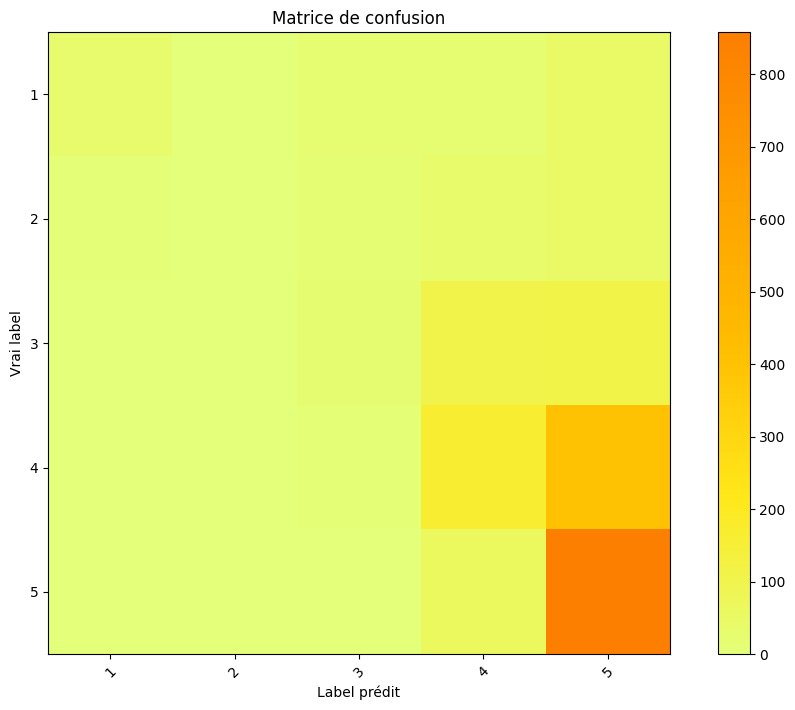

In [63]:
# Afficher la matrice de confusion
print("Matrice de confusion :")
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 7))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Wistia)
plt.title('Matrice de confusion')
plt.colorbar()
tick_marks = np.arange(len(np.unique(y)))
plt.xticks(tick_marks, np.unique(y), rotation=45)
plt.yticks(tick_marks, np.unique(y))
plt.tight_layout()
plt.ylabel('Vrai label')
plt.xlabel('Label prédit')
plt.show()

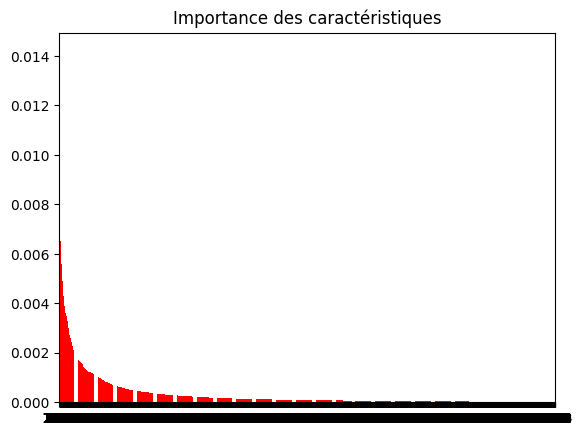

In [64]:
# Importance des caractéristiques
# Identifie les mots (caractéristiques) les plus influents pour la classification. Cela peut offrir des insights sur les aspects des avis qui affectent le plus la note attribuée.
importances = modelRFC.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure()
plt.title("Importance des caractéristiques")
plt.bar(range(X_train.shape[1]), importances[indices],
       color="r", align="center")
plt.xticks(range(X_train.shape[1]), indices)
plt.xlim([-1, X_train.shape[1]])
plt.show()

In [65]:
# Ajustement des hyperparamètres avec GridSearchCV
# Cherche la meilleure combinaison de paramètres (n_estimators, max_depth) pour améliorer la performance du modèle. Cela permet de trouver un compromis entre biais et variance, optimisant la capacité du modèle à généraliser.
param_grid = {'n_estimators': [100, 200], 'max_depth': [None, 10, 20]}
grid_search = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=5)
grid_search.fit(X_train, y_train)

#print("Meilleurs paramètres trouvés :")
print(grid_search.best_params_)

{'max_depth': None, 'n_estimators': 200}


In [66]:
# Entraîner le modèle avec les meilleurs paramètres
best_model = grid_search.best_estimator_

In [67]:
# Sauvegarder le modèle
joblib.dump(best_model, 'random_forest_model.joblib')

['random_forest_model.joblib']

In [68]:
# Charger le modèle
loaded_model = joblib.load('random_forest_model.joblib')

In [69]:
# Utiliser le modèle chargé pour faire des prédictions
loaded_model_pred = loaded_model.predict(X_test)
print("Rapport de classification du modèle chargé :")
print(classification_report(y_test, loaded_model_pred))

Rapport de classification du modèle chargé :
              precision    recall  f1-score   support

           1       0.83      0.32      0.46       118
           2       0.50      0.02      0.04       105
           3       0.42      0.09      0.15       236
           4       0.43      0.29      0.35       573
           5       0.59      0.93      0.72       922

    accuracy                           0.56      1954
   macro avg       0.55      0.33      0.34      1954
weighted avg       0.53      0.56      0.49      1954


In [70]:
# Charger le modèle RandomForest
modelRFC = joblib.load('random_forest_model.joblib')

In [88]:
# Nouvelle entrée d'avis
new_review = ["My experience at the hotel was decidedly underwhelming. Firstly, the location, while central, was a double-edged sword; the incessant noise from the street made a good night's sleep a rare luxury. The staff, although polite, seemed overwhelmed and occasionally unresponsive to requests for basic amenities. The room itself was a major letdown - cramped, with dated decor that felt more depressing than retro. The bed was uncomfortable, and the linens had seen better days. The air conditioning was more of a whisper than a relief, contributing to an overall stifling atmosphere. The breakfast, which I had looked forward to, was a disappointing affair with limited choices and stale pastries. In summary, the hotel was more a lesson in patience than a place of rest and relaxation."]

In [89]:
# Transformer l'avis en utilisant le vectoriseur TF-IDF chargé
new_review_tfidf = tfidf_vectorizer_3000.transform(new_review).toarray()

In [90]:
# Prédire la note pour la nouvelle entrée
predicted_note = modelRFC.predict(new_review_tfidf)

In [91]:
print("La note prédite pour l'avis est :", predicted_note[0])

La note prédite pour l'avis est : 4


### Model XBoost

In [75]:
# Charger les données
X = np.load('X_tfidf_1000.npy')
y = np.load('y.npy')

In [76]:
# Diviser les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [77]:
# Modifier les étiquettes pour qu'elles commencent à 0
y_train_adjusted = y_train - 1
y_test_adjusted = y_test - 1

In [78]:
# Initialiser le modèle XGBoost
model = XGBClassifier()

# Entraîner le modèle
model.fit(X_train, y_train_adjusted)

# Prédire les étiquettes sur l'ensemble de test
y_pred = model.predict(X_test)

In [79]:
# Afficher le rapport de classification
print("Rapport de classification :")
print(classification_report(y_test_adjusted, y_pred))

Rapport de classification :
              precision    recall  f1-score   support

           0       0.63      0.54      0.58       118
           1       0.35      0.22      0.27       105
           2       0.50      0.31      0.38       236
           3       0.46      0.43      0.44       573
           4       0.68      0.82      0.75       922

    accuracy                           0.59      1954
   macro avg       0.52      0.46      0.48      1954
weighted avg       0.57      0.59      0.58      1954


Matrice de confusion :


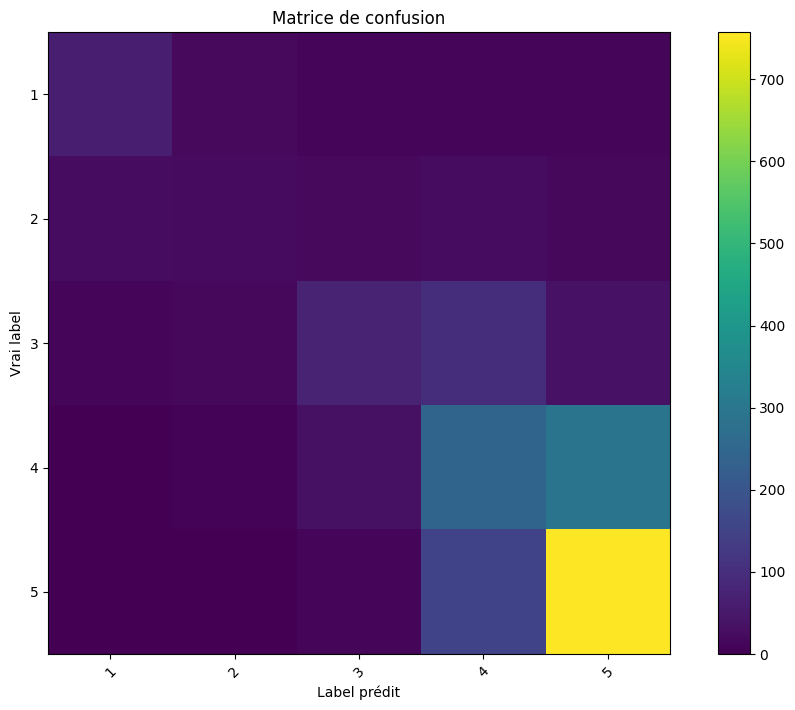

In [80]:
# Afficher la matrice de confusion
print("Matrice de confusion :")
cm = confusion_matrix(y_test_adjusted, y_pred)
plt.figure(figsize=(10, 7))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.viridis)  # Remplacement de Wistia par viridis
plt.title('Matrice de confusion')
plt.colorbar()
tick_marks = np.arange(len(np.unique(y)))
plt.xticks(tick_marks, np.unique(y), rotation=45)
plt.yticks(tick_marks, np.unique(y))
plt.tight_layout()
plt.ylabel('Vrai label')
plt.xlabel('Label prédit')
plt.show()

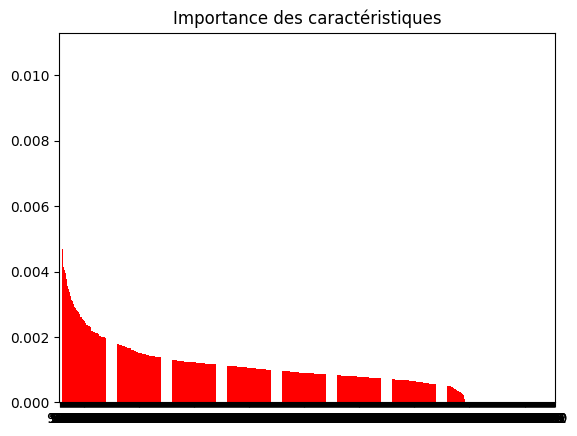

In [81]:
# Importance des caractéristiques
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure()
plt.title("Importance des caractéristiques")
plt.bar(range(X_train.shape[1]), importances[indices],
       color="r", align="center")
plt.xticks(range(X_train.shape[1]), indices)
plt.xlim([-1, X_train.shape[1]])
plt.show()

In [82]:
# Ajustement des hyperparamètres avec GridSearchCV
param_grid = {'n_estimators': [100, 200], 'max_depth': [None, 10, 20]}
grid_search = GridSearchCV(XGBClassifier(), param_grid, cv=5)
grid_search.fit(X_train, y_train_adjusted)

#print("Meilleurs paramètres trouvés :")
print(grid_search.best_params_)

{'max_depth': 10, 'n_estimators': 200}


In [83]:
# Entraîner le modèle avec les meilleurs paramètres
best_model = grid_search.best_estimator_

# Sauvegarder le modèle
joblib.dump(best_model, 'xgboost_model.joblib')

# Charger le modèle
loaded_model = joblib.load('xgboost_model.joblib')

In [84]:
# Utiliser le modèle chargé pour faire des prédictions
loaded_model_pred = loaded_model.predict(X_test)
print("Rapport de classification du modèle chargé :")
print(classification_report(y_test_adjusted, loaded_model_pred))

Rapport de classification du modèle chargé :
              precision    recall  f1-score   support

           0       0.63      0.55      0.59       118
           1       0.39      0.21      0.27       105
           2       0.54      0.32      0.40       236
           3       0.45      0.41      0.43       573
           4       0.67      0.82      0.73       922

    accuracy                           0.59      1954
   macro avg       0.53      0.46      0.48      1954
weighted avg       0.57      0.59      0.57      1954


In [92]:
# Nouvelle entrée d'avis
new_review = ["My experience at the hotel was decidedly underwhelming. Firstly, the location, while central, was a double-edged sword; the incessant noise from the street made a good night's sleep a rare luxury. The staff, although polite, seemed overwhelmed and occasionally unresponsive to requests for basic amenities. The room itself was a major letdown - cramped, with dated decor that felt more depressing than retro. The bed was uncomfortable, and the linens had seen better days. The air conditioning was more of a whisper than a relief, contributing to an overall stifling atmosphere. The breakfast, which I had looked forward to, was a disappointing affair with limited choices and stale pastries. In summary, the hotel was more a lesson in patience than a place of rest and relaxation."]

In [93]:
# Transformer l'avis en utilisant le vectoriseur TF-IDF chargé
new_review_tfidf = tfidf_vectorizer_1000.transform(new_review).toarray()

In [94]:
# Prédire la note pour la nouvelle entrée
predicted_note = loaded_model.predict(new_review_tfidf)
print("La note prédite pour l'avis est :", predicted_note[0])

La note prédite pour l'avis est : 3
